## Dependências

In [1]:
import os
import evaluate
import torch
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datasets import load_dataset, DatasetDict
from transformers import GraphormerForGraphClassification, TrainingArguments, Trainer
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator

d:\Visual Code\Graphormer\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Variáveis

In [2]:
load_dotenv()

token = os.getenv("TOKEN")

## Dataset

In [3]:
data_files = {
    "train": "../datasets/train.jsonl",        
    "test": "../datasets/test.jsonl",
    "validation": "../datasets/validation.jsonl",
}
dataset = load_dataset("json", data_files=data_files)
dataset = dataset.shuffle(seed=0)

Generating train split: 1164 examples [00:00, 86163.03 examples/s]
Generating test split: 318 examples [00:00, 28873.01 examples/s]
Generating validation split: 174 examples [00:00, 19280.59 examples/s]


## Métricas

In [4]:
metric = evaluate.load("accuracy")

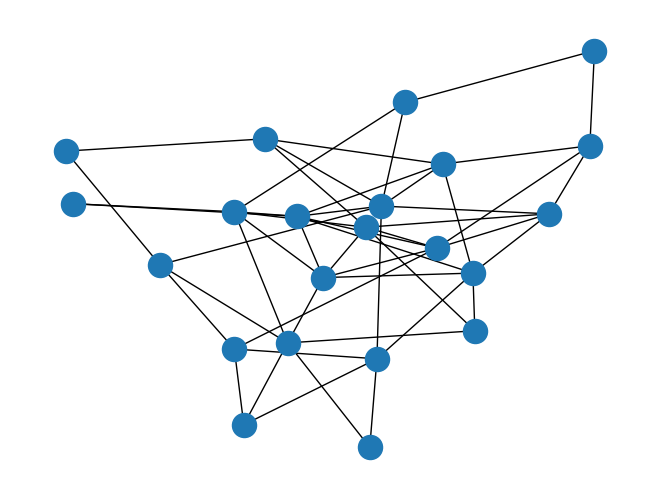

In [5]:
graph = dataset["train"][0]
edges = graph["edge_index"]
num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

nx.draw(G)

In [6]:
print("current_node:", graph["current_node"])
print("target_node:",  graph["target_node"])
print("proximo_salto:", graph["labels"])

current_node: 11
target_node: 14
proximo_salto: [0]


## Processamento de Dados

In [7]:
dataset_processed = dataset.map(preprocess_item, batched=False)
train_ds = dataset_processed['train']
val_ds = dataset_processed['validation']

Map: 100%|██████████| 174/174 [00:00<00:00, 538.92 examples/s]


In [8]:
train_ds[0].keys()

dict_keys(['graph_id', 'pair', 'path_len', 'num_nodes', 'edge_index', 'edge_attr', 'current_node', 'target_node', 'candidate_node', 'labels', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges'])

## Modelo

In [9]:
model = GraphormerForGraphClassification.from_pretrained(
    "clefourrier/pcqm4mv2_graphormer_base",
    token=token,
    num_edges=2048,
    num_classes=2,
    ignore_mismatched_sizes=True
)

d:\Visual Code\Graphormer\venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/pcqm4mv2_graphormer_base and are newly initialized because the shapes did not match:
- encoder.graph_encoder.graph_attn_bias.edge_encoder.weight: found shape torch.Size([1537, 32]) in the checkpoint and torch.Size([2049, 32]) in the model instantiated
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Argumentos

In [10]:
training_args = TrainingArguments(
    output_dir="../results",
    logging_dir="graph-classification",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    auto_find_batch_size=False,
    gradient_accumulation_steps=10,
    dataloader_num_workers=0, 
    num_train_epochs=20,
    evaluation_strategy="epoch",
    logging_strategy="epoch"    
)

## Treino

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=GraphormerDataCollator()
)

In [12]:
train_results = trainer.train()

  0%|          | 0/580 [00:00<?, ?it/s]d:\Visual Code\Graphormer\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Could not estimate the number of tokens of the input, floating-point operations will not be computed
  5%|▌         | 29/580 [01:07<20:46,  2.26s/it]

{'loss': 0.6975, 'grad_norm': 1.5291393995285034, 'learning_rate': 4.75e-05, 'epoch': 1.0}


                                                
  5%|▌         | 29/580 [01:11<20:46,  2.26s/it]

{'eval_loss': 0.6937498450279236, 'eval_runtime': 4.1613, 'eval_samples_per_second': 41.814, 'eval_steps_per_second': 10.574, 'epoch': 1.0}


 10%|█         | 58/580 [02:25<21:46,  2.50s/it]

{'loss': 0.6985, 'grad_norm': 4.249212741851807, 'learning_rate': 4.5e-05, 'epoch': 1.99}


                                                
 10%|█         | 58/580 [02:29<21:46,  2.50s/it]

{'eval_loss': 0.694007158279419, 'eval_runtime': 4.2013, 'eval_samples_per_second': 41.415, 'eval_steps_per_second': 10.473, 'epoch': 1.99}


 15%|█▌        | 87/580 [03:38<19:33,  2.38s/it]

{'loss': 0.6979, 'grad_norm': 1.8516771793365479, 'learning_rate': 4.25e-05, 'epoch': 2.99}


                                                
 15%|█▌        | 87/580 [03:42<19:33,  2.38s/it]

{'eval_loss': 0.6931801438331604, 'eval_runtime': 4.1884, 'eval_samples_per_second': 41.543, 'eval_steps_per_second': 10.505, 'epoch': 2.99}


 20%|██        | 116/580 [04:49<17:22,  2.25s/it]

{'loss': 0.6965, 'grad_norm': 6.351864814758301, 'learning_rate': 4e-05, 'epoch': 3.99}


                                                 
 20%|██        | 116/580 [04:53<17:22,  2.25s/it]

{'eval_loss': 0.6931790709495544, 'eval_runtime': 3.8834, 'eval_samples_per_second': 44.807, 'eval_steps_per_second': 11.33, 'epoch': 3.99}


 25%|██▌       | 145/580 [05:59<16:20,  2.25s/it]

{'loss': 0.6961, 'grad_norm': 0.34205594658851624, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.98}


                                                 
 25%|██▌       | 145/580 [06:03<16:20,  2.25s/it]

{'eval_loss': 0.6933088898658752, 'eval_runtime': 3.9066, 'eval_samples_per_second': 44.54, 'eval_steps_per_second': 11.263, 'epoch': 4.98}


 30%|███       | 174/580 [07:09<15:21,  2.27s/it]

{'loss': 0.6962, 'grad_norm': 2.924666404724121, 'learning_rate': 3.5e-05, 'epoch': 5.98}


                                                 
 30%|███       | 174/580 [07:13<15:21,  2.27s/it]

{'eval_loss': 0.6931606531143188, 'eval_runtime': 4.106, 'eval_samples_per_second': 42.377, 'eval_steps_per_second': 10.716, 'epoch': 5.98}


 35%|███▌      | 203/580 [08:20<15:01,  2.39s/it]

{'loss': 0.6957, 'grad_norm': 1.2803775072097778, 'learning_rate': 3.2500000000000004e-05, 'epoch': 6.98}


                                                 
 35%|███▌      | 203/580 [08:24<15:01,  2.39s/it]

{'eval_loss': 0.6934815049171448, 'eval_runtime': 4.0927, 'eval_samples_per_second': 42.515, 'eval_steps_per_second': 10.751, 'epoch': 6.98}


 40%|████      | 232/580 [09:30<13:07,  2.26s/it]

{'loss': 0.6967, 'grad_norm': 1.998724341392517, 'learning_rate': 3e-05, 'epoch': 7.97}


                                                 
 40%|████      | 232/580 [09:34<13:07,  2.26s/it]

{'eval_loss': 0.6931857466697693, 'eval_runtime': 3.9147, 'eval_samples_per_second': 44.448, 'eval_steps_per_second': 11.24, 'epoch': 7.97}


 45%|████▌     | 261/580 [10:39<12:06,  2.28s/it]

{'loss': 0.6961, 'grad_norm': 0.8609375953674316, 'learning_rate': 2.7500000000000004e-05, 'epoch': 8.97}


                                                 
 45%|████▌     | 261/580 [10:43<12:06,  2.28s/it]

{'eval_loss': 0.69316166639328, 'eval_runtime': 4.1085, 'eval_samples_per_second': 42.351, 'eval_steps_per_second': 10.71, 'epoch': 8.97}


 50%|█████     | 291/580 [11:49<10:26,  2.17s/it]

{'loss': 0.673, 'grad_norm': 1.1516886949539185, 'learning_rate': 2.4913793103448276e-05, 'epoch': 10.0}


                                                 
 50%|█████     | 291/580 [11:52<10:26,  2.17s/it]

{'eval_loss': 0.6931653022766113, 'eval_runtime': 3.8615, 'eval_samples_per_second': 45.06, 'eval_steps_per_second': 11.395, 'epoch': 10.0}


 55%|█████▌    | 320/580 [12:58<09:44,  2.25s/it]

{'loss': 0.6952, 'grad_norm': 1.814387321472168, 'learning_rate': 2.2413793103448276e-05, 'epoch': 11.0}


                                                 
 55%|█████▌    | 320/580 [13:02<09:44,  2.25s/it]

{'eval_loss': 0.6931576132774353, 'eval_runtime': 3.9235, 'eval_samples_per_second': 44.349, 'eval_steps_per_second': 11.215, 'epoch': 11.0}


 60%|██████    | 349/580 [14:07<08:48,  2.29s/it]

{'loss': 0.6967, 'grad_norm': 0.22060555219650269, 'learning_rate': 1.991379310344828e-05, 'epoch': 11.99}


                                                 
 60%|██████    | 349/580 [14:11<08:48,  2.29s/it]

{'eval_loss': 0.6931869983673096, 'eval_runtime': 3.874, 'eval_samples_per_second': 44.915, 'eval_steps_per_second': 11.358, 'epoch': 11.99}


 65%|██████▌   | 378/580 [15:17<07:55,  2.35s/it]

{'loss': 0.6959, 'grad_norm': 5.170743465423584, 'learning_rate': 1.7413793103448276e-05, 'epoch': 12.99}


                                                 
 65%|██████▌   | 378/580 [15:21<07:55,  2.35s/it]

{'eval_loss': 0.6933037042617798, 'eval_runtime': 3.9186, 'eval_samples_per_second': 44.403, 'eval_steps_per_second': 11.228, 'epoch': 12.99}


 70%|███████   | 407/580 [16:27<06:27,  2.24s/it]

{'loss': 0.6957, 'grad_norm': 2.021756649017334, 'learning_rate': 1.4913793103448276e-05, 'epoch': 13.99}


                                                 
 70%|███████   | 407/580 [16:31<06:27,  2.24s/it]

{'eval_loss': 0.6931902766227722, 'eval_runtime': 3.9438, 'eval_samples_per_second': 44.12, 'eval_steps_per_second': 11.157, 'epoch': 13.99}


 75%|███████▌  | 436/580 [17:36<05:24,  2.26s/it]

{'loss': 0.6962, 'grad_norm': 5.599515438079834, 'learning_rate': 1.2413793103448277e-05, 'epoch': 14.98}


                                                 
 75%|███████▌  | 436/580 [17:40<05:24,  2.26s/it]

{'eval_loss': 0.6931474804878235, 'eval_runtime': 3.8919, 'eval_samples_per_second': 44.708, 'eval_steps_per_second': 11.305, 'epoch': 14.98}


 80%|████████  | 465/580 [18:45<04:10,  2.18s/it]

{'loss': 0.695, 'grad_norm': 1.7749297618865967, 'learning_rate': 9.913793103448277e-06, 'epoch': 15.98}


                                                 
 80%|████████  | 465/580 [18:49<04:10,  2.18s/it]

{'eval_loss': 0.6931623220443726, 'eval_runtime': 4.0394, 'eval_samples_per_second': 43.076, 'eval_steps_per_second': 10.893, 'epoch': 15.98}


 85%|████████▌ | 494/580 [19:52<03:08,  2.20s/it]

{'loss': 0.6958, 'grad_norm': 0.9443843960762024, 'learning_rate': 7.413793103448275e-06, 'epoch': 16.98}


                                                 
 85%|████████▌ | 494/580 [19:56<03:08,  2.20s/it]

{'eval_loss': 0.6931514739990234, 'eval_runtime': 3.8532, 'eval_samples_per_second': 45.158, 'eval_steps_per_second': 11.419, 'epoch': 16.98}


 90%|█████████ | 523/580 [21:01<02:01,  2.13s/it]d:\Visual Code\Graphormer\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.6957, 'grad_norm': 1.080535888671875, 'learning_rate': 4.9137931034482765e-06, 'epoch': 17.97}


                                                 
 90%|█████████ | 523/580 [21:05<02:01,  2.13s/it]

{'eval_loss': 0.6931812763214111, 'eval_runtime': 4.5049, 'eval_samples_per_second': 38.624, 'eval_steps_per_second': 9.767, 'epoch': 17.97}


 95%|█████████▌| 552/580 [22:10<01:01,  2.20s/it]

{'loss': 0.6956, 'grad_norm': 0.9713822603225708, 'learning_rate': 2.413793103448276e-06, 'epoch': 18.97}


                                                 
 95%|█████████▌| 552/580 [22:14<01:01,  2.20s/it]

{'eval_loss': 0.6931485533714294, 'eval_runtime': 3.9314, 'eval_samples_per_second': 44.259, 'eval_steps_per_second': 11.192, 'epoch': 18.97}


100%|██████████| 580/580 [23:15<00:00,  2.24s/it]

{'loss': 0.6708, 'grad_norm': 0.8379660844802856, 'learning_rate': 0.0, 'epoch': 19.93}


                                                 
100%|██████████| 580/580 [23:19<00:00,  2.41s/it]

{'eval_loss': 0.6931530237197876, 'eval_runtime': 3.9422, 'eval_samples_per_second': 44.138, 'eval_steps_per_second': 11.161, 'epoch': 19.93}
{'train_runtime': 1399.9096, 'train_samples_per_second': 16.63, 'train_steps_per_second': 0.414, 'train_loss': 0.6938382872219744, 'epoch': 19.93}


## Save

In [13]:
trainer.save_model(output_dir="../model")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =    19.9313
  total_flos               =        0GF
  train_loss               =     0.6938
  train_runtime            = 0:23:19.90
  train_samples_per_second =      16.63
  train_steps_per_second   =      0.414
